#Gather trajectories

In [1]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_data = map( lambda x: x-width/2 , x_raw )
y_data = map( lambda x: x-height/2 , y_raw )

width = 1980.000000, height = 1093.000000


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

(-1000.0, 1000.0, -600.0, 600.0)

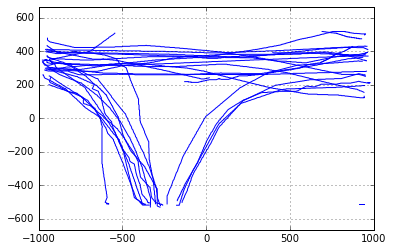

In [3]:
for k in range(len(x_data)):
    plt.plot(x_data[k], y_data[k],'b-')
plt.grid()
plt.axis('equal')

## The Model
We assume the trajectories are generated from Hamiltonian dynamics with respect to a Hamiltonian of the form
$$
    H(q,p;\theta) = \frac{1}{2} \dot{p}^2 + V(q;\theta).
$$
The potential function is parametrized by $\theta$ and takes the form
$$
    V(x,y ; \theta) = \sum_{k_1,k_2=0}^{k_\max} \theta[k_1,k_2] L_{k_1}(2x/w) L_{k_2}(2 y/h)
$$
where $L_k$ is the $k$th Legendre polynomial and $w,h$ are the width and height of the domain which is $[.

## Cost function
We hypothesize the trajectories are (roughly) generated by Euler-Lagrange equations with respect to a simple mechanical Lagrangian.  In order to learn the Lagrangian we consider what statistical mechanics dubs the *canonical distribution*
$$
    \rho_{can}(q,p; \theta) = \frac{1}{Z(\theta)} e^{- H(q,p;\theta) }
$$
where $Z(\theta) = \int e^{-H(q,p)} dq dp$.

We desire to learn the parameters $\theta$ by minimizing an appropriate cost function.
A reasonable cost function is the negative log likelyhood
$$
     C_1(\theta) = - \log\left[ \left( \prod_{k=0}^{N} \rho(q_{k} , p_{k} ;\theta) \right)^{1/N} \right] =
     \log \left(Z(\theta) \right) + \frac{1}{N} \sum_{k} H(q_k,p_k;\theta)
$$
As $\partial_\theta H(\cdot ; \theta) = \partial_\theta V( \cdot ; \theta)$
and
$$
    \log( Z(\theta) ) = \log \left( \int e^{p^2/2} dp \right) + \log\left( \int e^{-V(q,\theta)} dq \right)
$$

we can just use the cost function
$$
    C(\theta) = \log\left( \int e^{-V(q,\theta)} dq \right) + \frac{1}{N} \sum_{k} V(q_{k})
$$
This cost function incentivizes choosing a potential function which is low on the observed trajectory points, but high everywhere else.

In [105]:
#from sklearn.cross_validation import train_test_split
#help(train_test_split)

87
64
41


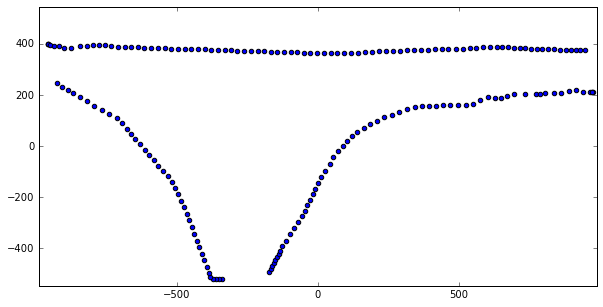

In [9]:
#points = [ (x,y) for k in range(len(x_data)) for x in list(x_data[k]) for y in list(y_data[k]) for k in range(len(x_data))]
#from numpy.random import choice
#sample_indices = choice( len(points), size=100)
#points_train = [ points[k] for k in sample_indices]

#for (x,y) in points_train:
#    plt.scatter(x,y)
#plt.show()
#points_x = np.random.randn(10)
#points_y

curves =[]
curve_indices = [0,6,14]
for k in curve_indices:
    curves.append( (x_data[k][0::5], y_data[k][0::5]) )

plt.figure(figsize=(10,5))
for (x,y) in curves:
    plt.scatter(x,y)
    print len(x)
domain = (-width/2,width/2,-height/2,height/2)
plt.axis(domain)
plt.show()

In [10]:
def get_time_scale(x,y):
    dx = x[1:] - x[0:len(x)-1]
    dy = y[1:] - y[0:len(y)-1]
    return (np.sqrt(dx**2 + dy**2)).sum() / float(len(dx))

In [18]:
V_scale = (width/2,height/2)
def cost_function(theta_flat , curves , k_max ):
    global width,height, V_scale
    V_sum = 0
    N = 0
    theta = theta_flat.reshape( (k_max+1, k_max+1))
    from numpy.polynomial.legendre import legval2d,leggauss
    for (x,y) in curves:
        V = legval2d( x/V_scale[0], y/V_scale[1], theta)
        V_sum += V.sum()
        N += len(x)
    k_span = np.arange( k_max+1)
    res = 2*(k_max+10)
    x_span = np.linspace(-width/2, width/2, res)
    y_span = np.linspace(-height/2, height/2, res)
    x_grid,y_grid = np.meshgrid(x_span, y_span)
    I = width*height*np.exp( - legval2d( x_grid/V_scale[0], y_grid/V_scale[1] , theta)).sum() / (res**2)
    regularization = np.einsum( 'ij,i,j', theta**2 , k_span**2 , k_span**2 )
    lambda_0 = 0.0
    return V_sum / float(N) + np.log(I) + lambda_0 * regularization

def potential_constraint(theta_flat, curves, k_max):
    global width,height
    return theta_flat[0]


def cb_function(theta_flat ):
    global k_max,curves
    print "Cost = %f" % cost_function(theta_flat , curves , k_max )
    return 0

k_max = 5
constraint_list = []
constraint_list.append({'type':'eq', 'fun':potential_constraint, 'args':(curves,k_max)} )

initial_guess = np.zeros( (k_max+1)**2 )

print cost_function(initial_guess, curves, k_max)
print potential_constraint(initial_guess, curves, k_max)
print cb_function(initial_guess)

14.5875336119
0.0
Cost = 14.587534
0


In [19]:
from scipy.optimize import minimize
res = minimize( cost_function , initial_guess , constraints=constraint_list , args = (curves, k_max ),
              callback = cb_function, options={'maxiter':1000})
print res.message
theta_opt = res.x.reshape( (k_max+1,k_max+1))

Cost = 14.438417
Cost = 14.166614
Cost = 14.134140
Cost = 14.015897
Cost = 13.975312
Cost = 13.963978
Cost = 13.940249
Cost = 13.930538
Cost = 13.919559
Cost = 13.911767
Cost = 13.901337
Cost = 13.887226
Cost = 13.873131
Cost = 13.865729
Cost = 13.857842
Cost = 13.851358
Cost = 13.842198
Cost = 13.832377
Cost = 13.826226
Cost = 13.823098
Cost = 13.821276
Cost = 13.819579
Cost = 13.817235
Cost = 13.815172
Cost = 13.813438
Cost = 13.811748
Cost = 13.809560
Cost = 13.806071
Cost = 13.801303
Cost = 13.797379
Cost = 13.795539
Cost = 13.794213
Cost = 13.792542
Cost = 13.790810
Cost = 13.789471
Cost = 13.788732
Cost = 13.788361
Cost = 13.787881
Cost = 13.787031
Cost = 13.785934
Cost = 13.784944
Cost = 13.784219
Cost = 13.783563
Cost = 13.782910
Cost = 13.782261
Cost = 13.781631
Cost = 13.780863
Cost = 13.779607
Cost = 13.777435
Cost = 13.774263
Cost = 13.771029
Cost = 13.768963
Cost = 13.768044
Cost = 13.767180
Cost = 13.765980
Cost = 13.764742
Cost = 13.763786
Cost = 13.762943
Cost = 13.7619

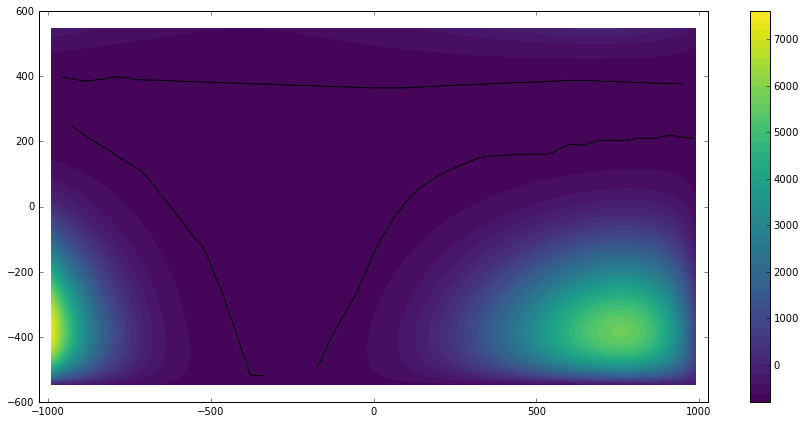

In [20]:
x_grid,y_grid = np.meshgrid( np.linspace(-width/2,width/2,50) , np.linspace(-height/2,height/2,50))
n_curves = len(curves)
from numpy.polynomial.legendre import legval2d
sigmoid = lambda x: np.exp(x)/(np.exp(x)+1)
V = legval2d(x_grid/V_scale[0] , y_grid/V_scale[1], theta_opt)
fig = plt.figure(figsize=(15,7))
plt.contourf(x_grid,y_grid,V , 50, cmap='viridis')
plt.colorbar()
for k in range(n_curves):
    plt.plot(curves[k][0] , curves[k][1],'k-')
axis_size= plt.axis('equal')

In [238]:
np.save('theta_opt_stat_mech',theta_opt)

## Sanity check
Let's see if we can reproduce the blue curves in the above plot using Stormer Verlet.

In [21]:
def Stormer_Verlet(x0,x1,y0,y1,n_steps, Delta_t):
    global width,height
    from numpy.polynomial.legendre import legder,legval2d
    theta_opt_x = legder( theta_opt, axis=0, m=1)
    theta_opt_y = legder( theta_opt, axis=1, m=1)
    x_pred = np.zeros(n_steps)
    y_pred = np.zeros(n_steps)
    x_pred[0],x_pred[1] = (x0,x1)
    y_pred[0],y_pred[1] = (y0,y1)    
    for k in range(n_steps-2):
        x1,y1 = (x_pred[k+1],y_pred[k+1])
        x0,y0 = (x_pred[k],y_pred[k])
        V_x = 2*legval2d( 2*x1/width, 2*y1/height, theta_opt_x )/width
        V_y = 2*legval2d( 2*x1/width, 2*y1/height, theta_opt_y )/height
        x_pred[k+2] = 2*x1 - x0 - Delta_t**2 * V_x
        y_pred[k+2] = 2*y1 - y0 - Delta_t**2 * V_y
    return np.array(x_pred),np.array(y_pred)

## Predictions on Test data
Let's do the same thing on some of the test data

335


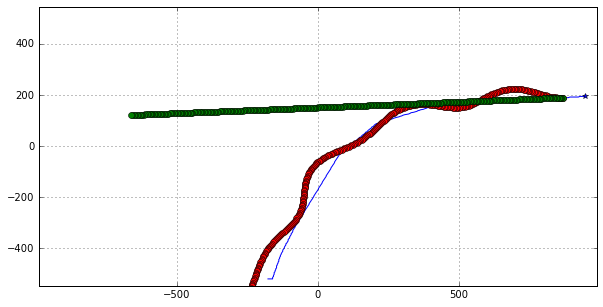

In [54]:
curve_ind = 17
start = 32
fd_width = 10
x0 = x_data[curve_ind][start]
u0 = (x_data[curve_ind][start+fd_width]-x_data[curve_ind][start-fd_width])/(2*fd_width)
y0 = y_data[curve_ind][start]
v0 = (y_data[curve_ind][start+fd_width]-y_data[curve_ind][start-fd_width])/(2*fd_width)
speed = np.sqrt(u0**2 + v0**2)
x1 = x0+u0
y1 = y0+v0
t_max = len(x_data[curve_ind])-start
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,t_max,1.0)
x_lin,y_lin = Stormer_Verlet(x0,x1,y0,y1,t_max,0.0)
fig = plt.figure(figsize=(10,5))
plt.plot(x_data[curve_ind], y_data[curve_ind],'b-')
plt.plot(x_data[curve_ind][0], y_data[curve_ind][0],'b*')
plt.plot(x_pred,y_pred,'ro')
plt.plot(x_lin,y_lin,'go')

plt.axis([-width/2,width/2,-height/2,height/2])
plt.grid(True)
print len(x_data[curve_ind])